<a href="https://colab.research.google.com/github/electropavuk/crypto_trader/blob/master/ipynb/system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from enum import IntEnum
import collections
from statistics import mean

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time


pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

np.set_printoptions(edgeitems=10, linewidth=200)
pd.options.mode.chained_assignment = None 

google_drive_dir = '/content/drive/MyDrive/Colab Notebooks/crypto_trader/'
data_dir = google_drive_dir + 'data/act_data/BTCUSDT/'

In [2]:
class Decision(IntEnum):
    SELL = -1
    WAIT = 0
    BUY = 1

# Trader

In [3]:
class BaseTrader:
    def __init__(self):
        pass

    def set_data(self, data):
        self.data = data



class PairTrader(BaseTrader):
    def __init__(self):
        self.balance = self.initial_money = 100
        self.quantity = 0
        self.trashold = .5
        self.trades = []
        self.profit = []
        self.time, self.times = 0, []

    def set_expert(self, pair_expert):
        self.expert = pair_expert

    def update(self, data):
        """Update candlesticks data, update expert.

        Args:
            data: Dictionary that maps timeframe name to new candlestick
            (Example: '1h' -> [...])
        """
        for timeframe, data in data.items():
            self.data[timeframe, 'History'].append(data)
            self.data[timeframe, 'History'].set_update_hash(time.time())
        self.expert.update()


    def act(self):
        estimation = self.expert.estimate()
        price = self.data['1h', 'History', 'Close'][-1]
        if estimation > self.trashold and self.balance > 0: # buy
            self.quantity = self.balance / price
            self.times.append(self.time)
            self.trades.append(('buy', self.quantity, price))
            self.balance = 0
        elif estimation < -self.trashold and self.quantity > 0: # sell
            self.balance = self.quantity * price
            self.times.append(self.time)
            self.trades.append(('sell', self.quantity, price))
            self.profit.append(self.evaluate_profit())
            self.quantity = 0
        self.time += 1


    def show_evaluation(self):
        if self.quantity > 0:
            self.balance = self.trades[-1][2] * self.quantity
            self.trades.pop()
            self.times.pop()
        print(f'{len(self.trades)} trades made')
        print(f'profit : {self.evaluate_profit():.2f} %')

    def evaluate_profit(self):
        return 100 * (self.balance - self.initial_money) / self.initial_money


# Data

In [4]:
class DataMaintainer:
    """Data Maintainer class for efficient data stream update.

    Args:
        _data: Dictionary that maps key to another DataMaintainer instance or deque.
        maxlen: Int. Maximum length of deque for columns.
    """

    def __init__(self, maxlen=2000):
        self._data = collections.defaultdict(DataMaintainer)
        self.maxlen = maxlen
        self.update_hash = None
    
    def __getitem__(self, keys):
        if not isinstance(keys, (tuple, list)):
            keys = (keys,)
        key, *other = keys
        if key not in self._data:
            raise KeyError(key)
        return self._data[key] if not other else self._data[key].__getitem__(other)

    def construct_location(self, keys):
        key, *other = keys
        return self._data[key] if not other else self._data[key].construct_location(other)

    def add(self, data=None, keys=[], location=None, maxlen=None):
        """Add data into the DataMaintainer.

        Args:
            data: Iterable. Contains columns to add.
            keys: Iterable. Contains keys for columns in same order.
            location: List. Contains subsequent keys for multikey access.
            maxlen: Int. Maximum length of deque for columns.
        """

        subunit = self.construct_location(location) if location else self
        subunit.maxlen = maxlen if maxlen is not None else self.maxlen
        for key, column in zip(keys, data if data is not None else [[] * len(keys)]):
            subunit._data[key] = collections.deque(column, maxlen=subunit.maxlen)
        return subunit

    def append(self, data, keys='auto'):
        """Append elements in data to deque specified by key.

        Args:
            data: Iterable. Elements to be added.
            keys: Iterable (optional). Contains keys for columns in same order.
                  By default keys are in the same order they were added.
        """
        keys = self._data.keys() if keys == 'auto' else keys
        for key, value in zip(keys, data):
            self._data[key].append(value)

    def set_update_hash(self, val):
        """Set hash representation of last time when data was updated"""
        self.update_hash = val

    def keys(self):
        return self._data.keys()

    def values(self):
        return self._data.values()

    def items(self):
        return self._data.items()

    def iterrows(self):
        for row in zip(*self.values()):
            return row

    def show(self, location='', show_last=10):
        maintainers, deques = [], []
        for key, obj in self._data.items():
            lst = maintainers if isinstance(obj, DataMaintainer) else deques
            lst.append((key, obj))
        
        for key, maintainer in maintainers:
                maintainer.show(f'{location}/{key}')
        print('\n' + location)
        for key, _ in deques:
            print(f'{key:>19}', end='')
        print('\n' * 2)
        cols = [list(val)[-show_last:] for key, val in deques]
        for attrs in zip(*cols):
            for val in attrs:
                print('{:>19.5f}'.format(val), end='')
            print()

# Experts

In [5]:
class BaseExpert:
    """Base Expert class for decision making."""

    def __init__(self):
        self.name = 'Base Expert'
        self._inner_experts = None
        self._weights = np.ones((len(self._inner_experts), 1))

    def set_experts(self, experts):
        self._inner_experts = experts
    
    def estimate(self):
        estimations = np.array([expert.estimate() for expert in self._inner_experts])
        # return estimations @ self._weights
        return np.mean(estimations)
    
    def update(self):
        for expert in self._inner_experts:
            expert.update()


class PairExpert(BaseExpert):
    """Expert class for handling specific trading pair.

    Args:
        base: String. Name of base currency.
        quote: String. Name of quote currency.
    """

    def __init__(self, base, quote):
        self.name = f'{base}/{quote} Expert'



class TimeFrameExpert(BaseExpert):
    """Expert class for handling specific timeframe.

    Args:
        timeframe: String. Name of timeframe (Example: '1h').
    """

    def __init__(self, timeframe):
        self.timeframe = timeframe
        self.name = f'{timeframe} Expert'



class RuleExpert(BaseExpert):
    """Expert class for handling specific trading rule.

    Args:
        indicators: List of BaseIndicator. Indicators to which rule is applied.
        rule: BaseRule. Trading rule that applies to indicators.
    """

    def __init__(self, indicators, rule):
        self._indicators = indicators
        self._rule = rule
        self.name = f'{self._rule.name} {str([indicator.name for indicator in self._indicators])}'

    def set_experts(self):
        raise SystemError('Do not call this method')

    def estimate(self):
        return self._rule.decide(*self._indicators)

    def update(self):
        for indicator in self._indicators:
            indicator.update()

# Indicators

In [6]:
class BaseIndicator:
    """Base Indicator Class
    
    Args:
        _data: DataMaintainer. If needed [_data] object will suply the indicator
            with necessary information, must have [self.name] key.
        _min_history: Int. Minimum number of candlestick required for state maintenance # ????????????
    """

    name = 'Base Indicator'

    def __init__(self):
        self._state = None
        self.update_hash = None

    def set_name(self):
        return f'{self.name} {self.get_parameters()}'

    def get_parameters(self):
        raise NotImplementedError()

    def init_state(self):
        """Calculate initial state"""
        raise NotImplementedError()

    def update(self):
        raise NotImplementedError()


class MovingAverageIndicator(BaseIndicator):
    name = 'MA'

    def __init__(self, data, length, source='Close', **kwargs):
        super().__init__(**kwargs)

        self.history = data['History']
        self.sma = SimpleMovingAverage(length=length)

        self.length = length
        self.source_name = source
        self.name = self.set_name()

        self._source = self.history[self.source_name]
        self.init_state()

    def init_state(self):
        for val in self._source:
            self.sma.append(val)

    def get_state(self):
        return self.sma.get_state()
            
    def update(self):
        # if the data was not already updated
        if self.update_hash != self.history.update_hash:
            self.update_hash = self.history.update_hash
            self.sma.append(self._source[-1])

    def get_parameters(self):
        return [self.length, self.source_name]

# Rolling windows

In [7]:
class BaseRollingWindow:
    def __init__(self, length):
        self.length = length
        self.queue = collections.deque()
        self.state = 0



class SimpleMovingAverage(BaseRollingWindow):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def append(self, val):
        if len(self.queue) >= self.length:
            self.state -= self.queue.popleft() / self.length
        self.state += val / self.length
        self.queue.append(val)

    def get_state(self):
        return self.state

# Rules

In [8]:
class BaseRule:
    name = 'Base Rule'
    
    def __init__(self, patience=1):
        self._state = None
        self._patience = patience

    def update(self):
        raise NotImplementedError()
    
    def decide(self):
        raise NotImplementedError()



class BaseCrossoverRule(BaseRule):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # number of steps that first / second line dominates (is higher) the other
        self.a = self.b = float('inf') 

    def cross(self, a, b):
        if a > b:
            self.a += 1
            self.b = 0
        else:
            self.b += 1
            self.a = 0
        return self.a, self.b



class BaseTrasholdRule(BaseRule):
    def __init__(self, lower, upper, **kwargs):
        super().__init__(**kwargs)
        self.upper = upper
        self.lower = lower



class MACrossoverRule(BaseCrossoverRule):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def decide(self, slow, fast):
        buy, sell = self.cross(fast.get_state(), slow.get_state())
        if buy == self._patience:
            return Decision.BUY
        elif sell == self._patience:
            return Decision.SELL
        else:
            return Decision.WAIT

# Simulation


/1h/History
          Open time               Open               High                Low              Close             Volume         Close time Quote asset volume   Number of tradesTaker buy base asset volumeTaker buy quote asset volume             Ignore


1627491600000.00000        40119.86000        40247.99000        38800.00000        38961.00000         6662.627561627495199999.00000    262720962.27113       146692.00000         2991.69068    118003342.20849            0.00000
1627495200000.00000        38961.01000        40500.00000        38772.00000        40440.99000         7207.661611627498799999.00000    286746694.92022       123100.00000         3828.36463    152369647.71128            0.00000
1627498800000.00000        40440.99000        40680.07000        39929.49000        40388.61000         4529.760231627502399999.00000    182776436.59890       182393.00000         2228.32465     89924406.93804            0.00000
1627502400000.00000        40388.61000        40388.

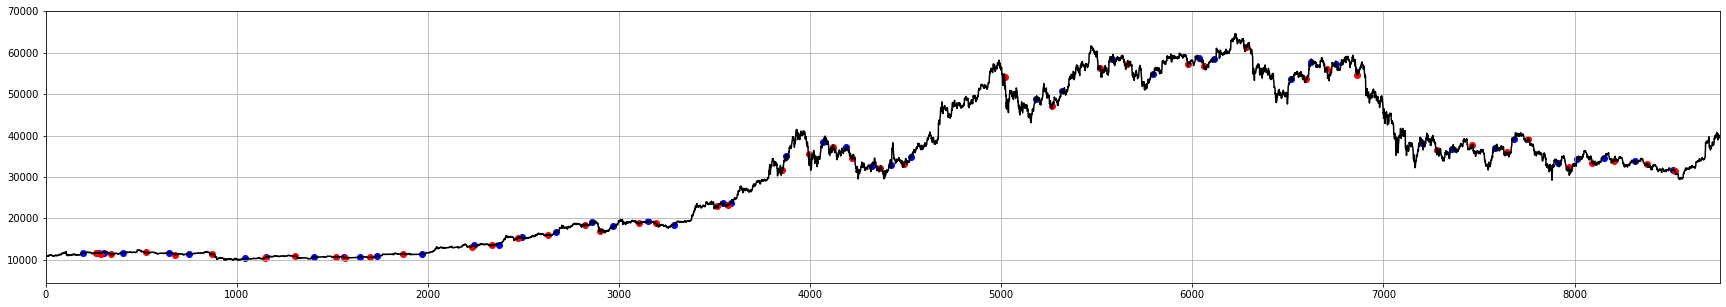

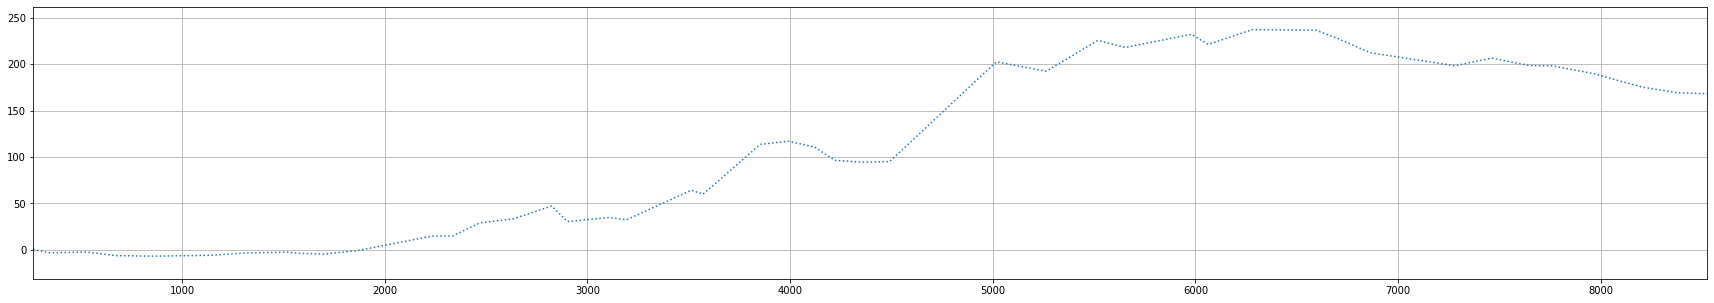

In [9]:
class Simulation:
    def simulate(self, history, timeframe, n):
        pair = 'BTC/USDT'
        old_history, new_history = history.iloc[:-n], history.iloc[-n:]

        historical_data = DataMaintainer()
        historical_data.add(data=old_history.values.T, keys=list(history), location=[pair, '1h', 'History'])

        pair_trader = PairTrader()
        pair_trader.set_data(historical_data[pair])

        inds = [MovingAverageIndicator(historical_data[pair, '1h'], 90),
                MovingAverageIndicator(historical_data[pair, '1h'], 25)]
        rule = MACrossoverRule(patience=5)
        
        rule_exp = RuleExpert(inds, rule)
        tf_exp = TimeFrameExpert('1h')
        pair_exp = PairExpert(*pair.split('/'))

        tf_exp.set_experts([rule_exp])
        pair_exp.set_experts([tf_exp])

        pair_trader.set_expert(pair_exp)

        for idx, row in new_history.iterrows():
            pair_trader.update({'1h': row})
            pair_trader.act()

        plot(new_history['Close'], pair_trader)        


def plot(close, trader):
    n = len(close)
    trader.data.show()
    trader.show_evaluation()

    buy, sell = trader.trades[::2], trader.trades[1::2]
    buy_time, sell_time = trader.times[::2], trader.times[1::2]

    config_plot(plt)

    plt.plot(range(n), close, color='black')
    plt.scatter(buy_time, [x[2] for x in buy], color='blue')
    plt.scatter(sell_time, [x[2] for x in sell], color='red')

    config_plot(plt)
    plt.plot(sell_time, trader.profit, linestyle=':')


def config_plot(plt):
    plt.figure(figsize = (30, 5))
    plt.margins(0, .1)
    plt.grid(True)


def load_history(filename):
    return pd.read_csv(data_dir + filename)


history = load_history('1h.csv')
n = 24 * 365
simulation = Simulation()
simulation.simulate(history, '1h', n)

# Main